In [1]:
import os
import json
import librosa
import numpy as np

import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

import solver
from model import Net
from dataset import AudioEffectDataset
from config import SR, WIN_LEN, HOP_LEN

import torch

In [2]:
path_json = 'data/file_pair.json'
with open(path_json, 'r') as f:
    pair_list = json.load(f)
path_npz_test = os.path.join('data', 'processed_test.npz')
test_set = AudioEffectDataset(pair_list['test'], path_npz_test, None, is_seg=False)


results = np.load('tmp.npz')
y_pred = results['data']
scroe = results['score']

[o] processed data exists


In [3]:
model = Net()
model = solver.restore('exp')
model.eval()
print('loaded')

loaded


In [4]:
test_set[0]['x'].shape

torch.Size([32001])

In [5]:
32001 / 1024

31.2509765625

In [92]:
sr = SR
idx = 0
wav_x = test_set[idx]['x']
wav_y = test_set[idx]['y']
block_list_x = []
block_list_y = []
wav_len = min(len(wav_x), len(wav_y))
print('wav_len:', wav_len)
for i in range(0, wav_len, WIN_LEN):
    st = i
    ed = i + WIN_LEN
    if ed > wav_len:
        break
    block_x = np.expand_dims(wav_x[st:ed].numpy(), axis=0)
    block_list_x.append(block_x)
    block_y = np.expand_dims(wav_y[st:ed].numpy(), axis=0)
    block_list_y.append(block_y)

wav_len: 32001


In [93]:
tensor_x = np.array(block_list_x)
tensor_x = torch.from_numpy(tensor_x).float()

tensor_y = np.array(block_list_y)
tensor_y = torch.from_numpy(tensor_y).float()

In [94]:
tensor_y_pred = model(tensor_x)
tensor_y_pred = torch.squeeze(tensor_y_pred)
print('tensor_y_pred:', tensor_y_pred.size())
tensor_y = torch.squeeze(tensor_y)
print('tensor_y:', tensor_y.size())
loss = model.compute_loss(tensor_y, tensor_y_pred)
print('loss:', loss.item())

tensor_y_pred: torch.Size([31, 1024])
tensor_y: torch.Size([31, 1024])
loss: 0.028925267979502678


In [102]:
restore_x = np.concatenate(torch.squeeze(tensor_x).numpy())
restore_y = np.concatenate(tensor_y.numpy())
restore_y_pred = np.concatenate(tensor_y_pred.detach().numpy())

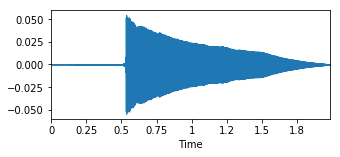

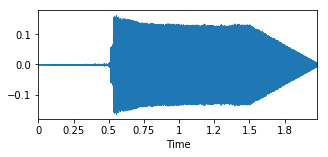

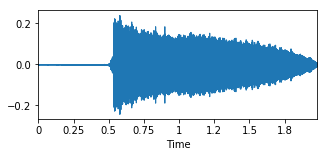

In [103]:
plt.figure(figsize=(5, 2))
librosa.display.waveplot(restore, sr=sr)
plt.figure(figsize=(5, 2))
librosa.display.waveplot(restore_y, sr=sr)
plt.figure(figsize=(5, 2))
librosa.display.waveplot(restore_y_pred, sr=sr)

In [118]:
librosa.output.write_wav('x.wav', restore_x, sr=SR)
ipd.Audio(restore_x, rate=sr)

In [119]:
librosa.output.write_wav('y.wav', restore_y, sr=SR)
ipd.Audio(restore_y, rate=sr)

In [120]:
librosa.output.write_wav('y_pred.wav', restore_y_pred, sr=SR)
ipd.Audio(restore_y_pred, rate=sr)

### from scratch

In [139]:
wav_test, _ = librosa.load('ref-NOFX.wav', sr=SR)
wav_len = len(wav_test)
block_list = []
for i in range(0, wav_len, WIN_LEN):
    st = i
    ed = i + WIN_LEN
    if ed > wav_len:
        break
    block = np.expand_dims(wav_test[st:ed], axis=0)
    block_list.append(block)
    
tensor_t = np.array(block_list)
tensor_t = torch.from_numpy(tensor_t).float()
tensor_y_pred_t = model(tensor_t)

In [140]:
tensor_t = torch.squeeze(tensor_t)
restore_x = np.concatenate(tensor_t.numpy())

In [144]:
tensor_y_pred_t = torch.squeeze(tensor_y_pred_t)
restore_y = np.concatenate(tensor_y_pred_t.detach().numpy())
print(restore_y.shape)

(74752,)


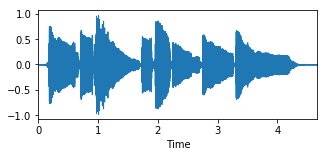

In [149]:
plt.figure(figsize=(5, 2))
librosa.display.waveplot(restore_x, sr=sr)

In [142]:
librosa.output.write_wav('x_test.wav', restore_x, sr=SR)
ipd.Audio(restore_x, rate=SR)

In [157]:
librosa.output.write_wav('y_test.wav', restore_y, sr=SR, norm=True)
ipd.Audio(restore_y, rate=sr)

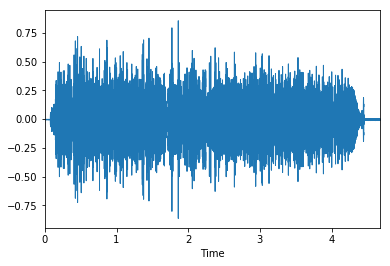

In [150]:
librosa.display.waveplot(restore_y, sr=sr)

In [154]:
tmp, _= librosa.load('y_test.wav', sr=SR)
np.min(tmp), np.max(tmp)

(-1.0, 0.43078613)